The aim of this notebook is to introduce an AutoEncoder model for multi-modal integration of the ATAC + GEX data. The multi-modal AutoEncoder idea will be taken from (https://ieeexplore.ieee.org/document/8715409) - specifically Figure 4.

We'll extend this idea to the gene-expression and atac-seq data. We'll select variable features for both modalities and then jointly encode the gex and atac-seq data into the same space. After training and monitoring the loss to a certain extent, we'll freeze model training and get the embeddings (from the latent space) for the multi-modal data and then test to see how well this does based on our evaluation (and see if it's better than simply concatenating the PCA reduction of each modality individually).

Let's get started by loading the single-cell libraries, the data, and getting the variable features from both modalities. We'll restrict ourselves to 2500 features for GEX and 5000 features for ATAC/chromatin accessibility

In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc 
import anndata as ann
import episcanpy as esc

In [2]:
os.chdir("..")
multiome = sc.read_h5ad("data/multimodal/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [3]:
gex = multiome[:, multiome.var["feature_types"] == "GEX"] # Subset all data, not just the counts 
sc.pp.highly_variable_genes(gex, n_top_genes=2500, flavor="seurat_v3") # Feature selection

Trying to set attribute `._uns` of view, copying.


In [4]:
atac = multiome[:, multiome.var["feature_types"] == "ATAC"] # Subset all data, not just the counts 
esc.pp.select_var_feature(atac, nb_features=5000, show=False) # Feature-selection - most variable features

Trying to set attribute `.var` of view, copying.


Let's go ahead and load the tensorflow libraries

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

2022-11-22 19:45:47.978661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We'll extract our GEX and ATAC data and load it into tensorflow tensors

In [6]:
hvg_indices = gex.var["highly_variable"]
gex_arr = gex.X.todense()[:, hvg_indices]
gex_tensor = tf.convert_to_tensor(gex_arr)

2022-11-22 19:46:29.564842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
gex_tensor.shape

TensorShape([69249, 2500])

In [8]:
atac_arr = atac.X.todense()
atac_tensor = tf.convert_to_tensor(atac_arr)

In [9]:
atac_tensor.shape

TensorShape([69249, 5001])

One extra dimension in the ATAC data, but we don't need to worry about that. We'll just say that the dimensionality of our ATAC data is 5001. We'll input both datatypes as a concatenated representation

In [10]:
gex_atac_concat = tf.concat([gex_tensor, atac_tensor], axis = 1)
gex_atac_concat.shape

TensorShape([69249, 7501])

Lets go ahead and create our AutoEncoder model now

In [22]:
latent_dim = 20 # Specify the size of our latent dimension 
gex_dim = 2500
atac_dim = 5001

# Create the model class for our AutoEncoder - this follows mostly for the tutorial from 
# https://www.tensorflow.org/tutorials/generative/autoencoder, except we're putting a multi-modal
# flavor on it and ensuring it uses and reconstructs both GEX and ATAC outputs 
class MultiModalAutoencoder(Model):
    def __init__(self, latent_dim, gex_dim, atac_dim):
        super(MultiModalAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.gex_dim = gex_dim
        self.atac_dim = atac_dim
        # We have two encoders and decoder - for each modality
        # We divide latent dim by two because we are going to 
        # concatenate the two modalities in latent space and
        # then use that concatenated representation to reconstruct
        # each modality 
        self.gex_encoder = tf.keras.Sequential([
            layers.Dense(250, activation="relu"),
            layers.Dense(latent_dim/2, activation="relu")
        ])
        self.atac_encoder = tf.keras.Sequential([
            layers.Dense(250, activation="relu"),
            layers.Dense(latent_dim/2, activation="relu")
        ])
        self.latent_concat = tf.keras.layers.Concatenate(
            axis=-1
        )
        self.outputs_concat = tf.keras.layers.Concatenate(
            axis=-1
        )
        self.gex_decoder = tf.keras.Sequential([
            layers.Dense(250, activation = "relu"),
            layers.Dense(gex_dim, activation = "relu")
        ])
        self.atac_decoder = tf.keras.Sequential([
            layers.Dense(250, activation = "relu"),
            layers.Dense(atac_dim, activation = "relu")
        ])
        
    def call(self, gex_atac_X):
        # Extract the data
        gex_X = gex_atac_X[:, 0:2500]
        atac_X = gex_atac_X[:, 2500:]
        # Encode both the GEX and ATAC data 
        gex_Z = self.gex_encoder(gex_X)
        atac_Z = self.atac_encoder(atac_X)
        # Concatenate the two encoded modalities 
        gex_atac_c = self.latent_concat([gex_Z, atac_Z]) # This is our latent we'll use later
        # Use the concatenated representation to recover both GEx and ATAC
        gex_X_decoded = self.gex_decoder(gex_atac_c)
        atac_X_decoded = self.atac_decoder(gex_atac_c)
        gex_atac_X_decoded = self.outputs_concat([gex_X_decoded, atac_X_decoded])
        return gex_atac_X_decoded 
    
# We're going to define a custom loss as we need a separate loss for both modalities 
# For GEX, since the data is continuous, we can use a mean-squared error loss 
# For ATAC, since the data is binary, we'll use a binarycrossentropy loss 
# We'll combine these to have even weight for now - but the scaling can be played around with
# (And maybe even treated as a hyperparameter)
def multimodal_loss(gex_atac_true, gex_atac_pred):
    # GEX loss 
    mse = tf.keras.losses.MeanSquaredError()
    gex_true = gex_atac_true[:, 0:2501]
    gex_pred = gex_atac_pred[:, 0:2501]
    gex_loss = mse(gex_true, gex_pred)
    
    # ATAC loss 
    bce = tf.keras.losses.BinaryCrossentropy()
    atac_true = gex_atac_true[:, 2501:]
    atac_pred = gex_atac_pred[:, 2501:]
    atac_loss = bce(atac_true, atac_pred)
    
    # Combine both and return
    loss = gex_loss*10 + atac_loss*1
    return loss 

Let's compile the autoencoder and train for 10 epochs

In [23]:
autoencoder = MultiModalAutoencoder(latent_dim, gex_dim, atac_dim)
autoencoder.compile(optimizer='adam', loss=multimodal_loss)

In [24]:
autoencoder.fit(gex_atac_concat, gex_atac_concat,
                epochs=10,
                shuffle=True,
                batch_size=512
               )

Epoch 1/10
136/136 [==============================] - 27s 189ms/step - loss: 378.6716
Epoch 2/10
136/136 [==============================] - 26s 189ms/step - loss: 66.7439
Epoch 3/10
136/136 [==============================] - 25s 187ms/step - loss: 65.3526
Epoch 4/10
136/136 [==============================] - 26s 189ms/step - loss: 63.0308
Epoch 5/10
136/136 [==============================] - 26s 188ms/step - loss: 60.7138
Epoch 6/10
136/136 [==============================] - 25s 187ms/step - loss: 59.8716
Epoch 7/10
136/136 [==============================] - 26s 189ms/step - loss: 59.3596
Epoch 8/10
136/136 [==============================] - 26s 189ms/step - loss: 59.4507
Epoch 9/10
136/136 [==============================] - 25s 187ms/step - loss: 59.0669
Epoch 10/10
136/136 [==============================] - 26s 188ms/step - loss: 59.1993


Now let's go ahead and freeze the model and extract the results for both modalities. We'll simply concatenate them together to get a 20 dimensional array and use that as our representation to evaluate

In [25]:
autoencoder.trainable = False # Freezes model

In [26]:
gex_Z = autoencoder.gex_encoder(gex_tensor) # Get GEX reduction 
gex_Z.shape

TensorShape([69249, 10])

In [27]:
atac_Z = autoencoder.atac_encoder(atac_tensor) # Get ATAC reduction
atac_Z.shape

TensorShape([69249, 10])

In [28]:
Z_concat = tf.concat([gex_Z, atac_Z], axis = 1)
Z_concat.shape

TensorShape([69249, 20])

In [29]:
Z_concat_arr = Z_concat.numpy()
Z_concat_arr.shape

(69249, 20)

Now let's call the evaluate function like before (notebook 03) and see how well this autoencoder did 

In [30]:
from helpers.eval_embeddings import EvalEmbeddings

In [31]:
eval_obj = EvalEmbeddings(adata=gex) # Initialize the class
eval_obj.evaluate(Z_concat_arr) # Evaluate

(0.5796382179281934,
    celltype_ari  celltype_ami  celltype_homogeneity  celltype_complete  \
 0      0.265721      0.535311              0.580114           0.498037   
 
    batch_ari  batch_ami  batch_homogeneity  batch_complete  
 0   0.852044   0.711466           0.673498        0.740599  )

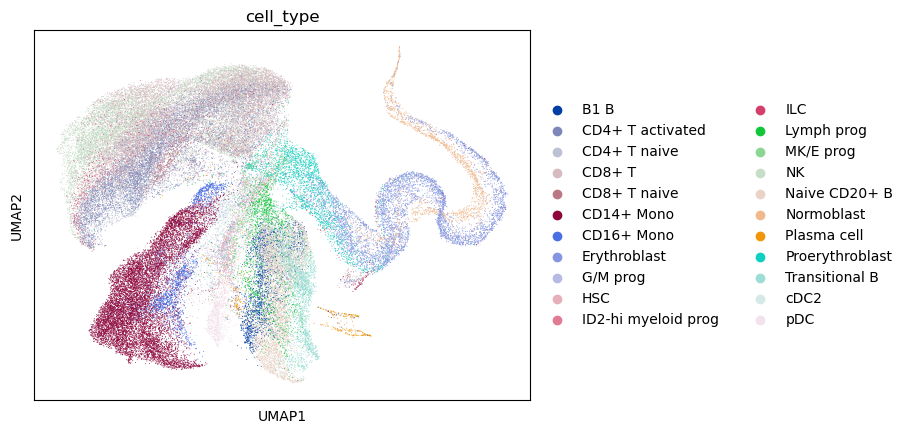

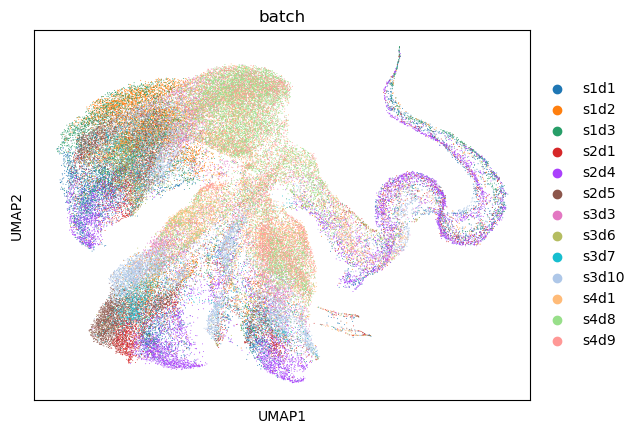

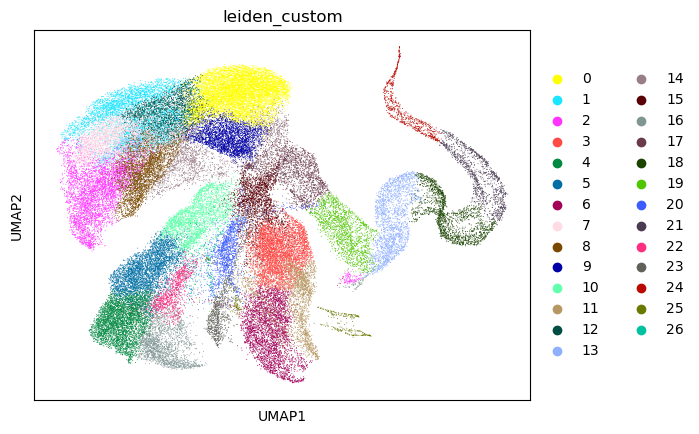

In [32]:
eval_obj.plot() # Plot the results 